# **Module 3: Raster Data in Python**

#### Data
In this example, we will create some raster data to imitate real-world data. We will use `data-module-3` as a workspace. We have also prepared the following datasets:
- `ndvi_summer.tif` and `ndvi_winter.tif` - Normalized Difference Vegetation Index (NDVI) for a study area in Kansas. NDVI is an indicator of vegetation health. Data was acquired by Landsat 8 and exported from Climate Engine at http://climateengine.org.
- `ag_fields.shp` - selected agricultural fields for a study area in Kansas.
- `friction_mali.tif` - a friction surface that quanitfies travel cost for a sample study area in Mali.

#### Software
To execute the code you will need a Python environment with the packages imported below. The default environment does not have all required packages to execute this script. Therefore, run the following command beforehand:
- `pip install xarray xarray-spatial --user`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import Affine
from rasterio.plot import plotting_extent
from rasterio.enums import Resampling
from rasterstats import zonal_stats
import xarray as xr
from xrspatial.convolution import circle_kernel
import xrspatial.zonal, xrspatial.focal
import geopandas as gpd
import skimage.graph as graph

### **Raster Data Review**

#### Create a raster

To generate raster data in Python we rely on `numpy` and `rasterio` packages. We need the following three components:
- An array of data and the xy coordinates;
- A Coordinate Reference System;
- A transform defining the coordinate of the upper left hand corner of the array.

In [2]:
ras_0 = np.zeros([6, 6])

ras_a = np.arange(1, 37).reshape(6, 6)

np.random.seed(0)
ras_b = np.random.randint(100, size=(6,6))

Text(0.5, 1.0, 'ras_b (Random Integers)')

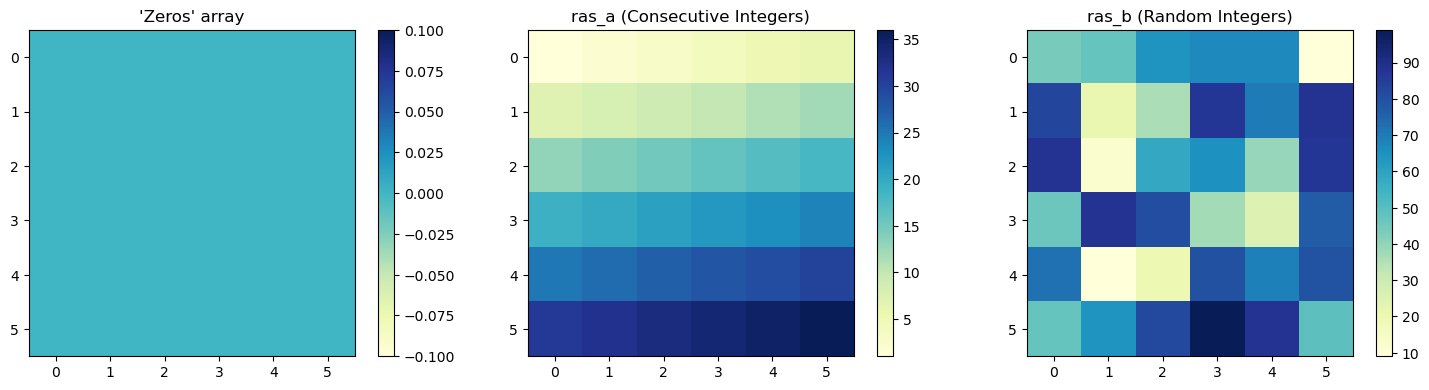

In [3]:
fig, axs = plt.subplots(1,3, figsize=(15,4), tight_layout=True)

plot0 = axs[0].imshow(ras_0, cmap="YlGnBu")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("'Zeros' array")

plot1 = axs[1].imshow(ras_a, cmap="YlGnBu")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("ras_a (Consecutive Integers)")

plot2 = axs[2].imshow(ras_b, cmap="YlGnBu")
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("ras_b (Random Integers)")

In [4]:
x = np.linspace(-1.25, 1.25, 6)
y = np.linspace(-1.25, 1.25, 6)
X, Y = np.meshgrid(x, y)

Text(0.5, 1.0, 'latitude')

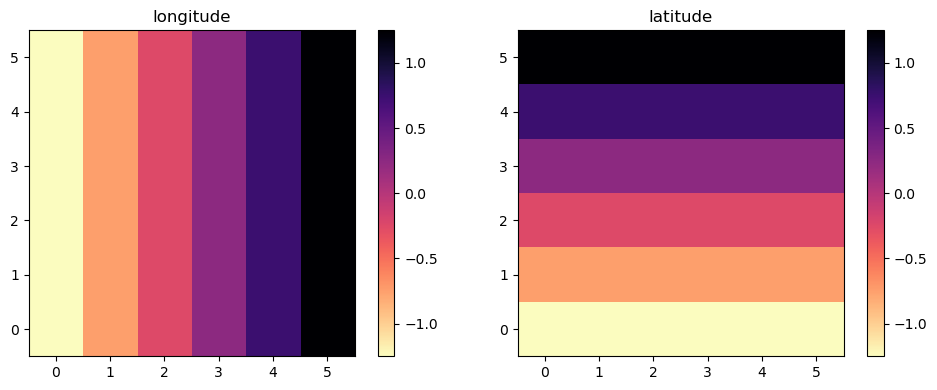

In [5]:
fig, axs = plt.subplots(1,2, figsize=(10,4),  tight_layout=True)

plot0 = axs[0].imshow(X, cmap="magma_r", origin="lower")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("longitude")

plot1 = axs[1].imshow(Y, cmap="magma_r",origin="lower")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("latitude")

In [6]:
res = 0.5
transform = Affine.translation(x[0] - res / 2, -(y[0] - res / 2)) * Affine.scale(res, -res)

with rasterio.open("./data-module-3/ras_a.tif",
                   "w",
                   height=ras_a.shape[0],
                   width=ras_a.shape[1],
                   count=1,
                   dtype=np.int16,
                   crs="epsg:4326",
                   transform=transform,
                   nodata=-999
                  ) as dst:
     dst.write(ras_a, 1)

#### Read raster data from a file

In [7]:
ndvi_winter = rasterio.open("./data-module-3/ndvi_winter.tif")
ndvi_summer = rasterio.open("./data-module-3/ndvi_summer.tif")

print (f"Dataset CRS is {ndvi_summer.crs}")
print (f"Dataset extent is {ndvi_summer.bounds}")
print (f"Dataset resolution is {ndvi_summer.res}")
print (f"Dataset NoData is {ndvi_summer.nodata}")
print("Dataset transform is below")
ndvi_summer.transform

Dataset CRS is EPSG:4326
Dataset extent is BoundingBox(left=-100.71605538351474, bottom=37.25250601173768, right=-100.51177848790597, top=37.45354897232363)
Dataset resolution is (0.000269494585235846, 0.0002694945852358598)
Dataset NoData is -9999.0
Dataset transform is below


Affine(0.000269494585235846, 0.0, -100.71605538351474,
       0.0, -0.0002694945852358598, 37.45354897232363)

**How to read Affine matrix (a, b, c, d, e, f)?**
- a = width of a pixel
- b = row rotation (typically zero)
- c = x-coordinate of the upper-left corner of the upper-left pixel
- d = column rotation (typically zero)
- e = height of a pixel (typically negative)
- f = y-coordinate of the of the upper-left corner of the upper-left pixel.

**Note that when you read a raster dataset with `rasterio` the interpretation of the 3 axes is `(bands, rows, columns)`.**

In [10]:
array = ndvi_summer.read(1)
array.shape

(746, 758)

In [14]:
array[array==ndvi_summer.nodata]=np.nan

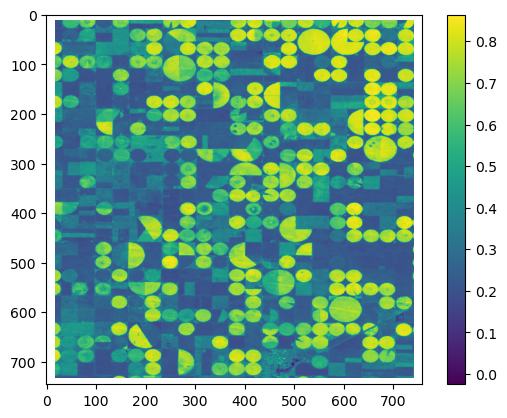

In [15]:
plt.imshow(array)
plt.colorbar()

In [16]:
ndvi_winter_array = ndvi_winter.read(1)
ndvi_winter_array[ndvi_winter_array==ndvi_winter.nodata] = np.nan

ndvi_summer_array = ndvi_summer.read(1)
ndvi_summer_array[ndvi_summer_array==ndvi_summer.nodata] = np.nan

Text(0.5, 1.0, 'NDVI summer')

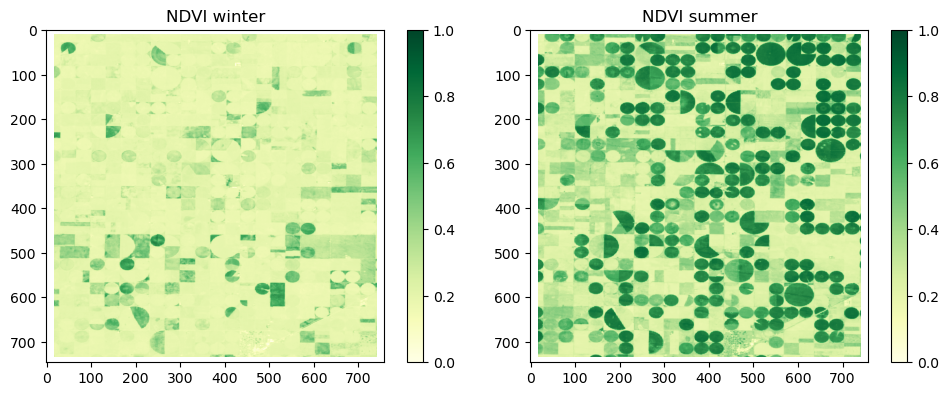

In [17]:
fig, axs = plt.subplots(1,2, figsize=(10,4), tight_layout=True)

plot0 = axs[0].imshow(ndvi_winter_array, cmap="YlGn", clim=(0,1))
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("NDVI winter")

plot1 = axs[1].imshow(ndvi_summer_array, cmap="YlGn",  clim=(0,1))
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("NDVI summer")

#### Summarize raster data
Below we present some methods to summarize and describe array data with common statistics.

(array([3., 3., 0., 4., 4., 1., 7., 4., 9., 1.]),
 array([ 9., 18., 27., 36., 45., 54., 63., 72., 81., 90., 99.]),
 <BarContainer object of 10 artists>)

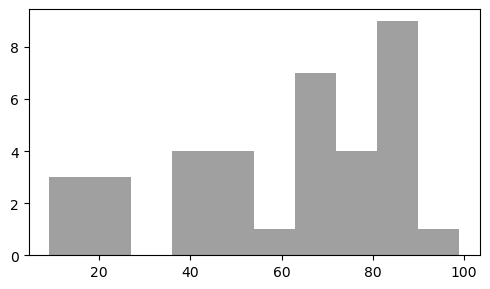

In [18]:
fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
ax.hist(ras_b.flatten(), facecolor="grey", alpha=0.75)

(array([1.00000e+00, 5.60000e+01, 3.83000e+02, 2.19843e+05, 2.23171e+05,
        4.24310e+04, 2.14450e+04, 1.20030e+04, 6.45400e+03, 1.28900e+03]),
 array([-0.18876757, -0.09397249,  0.00082259,  0.09561767,  0.19041274,
         0.28520784,  0.38000292,  0.47479799,  0.56959307,  0.66438812,
         0.75918323]),
 <BarContainer object of 10 artists>)

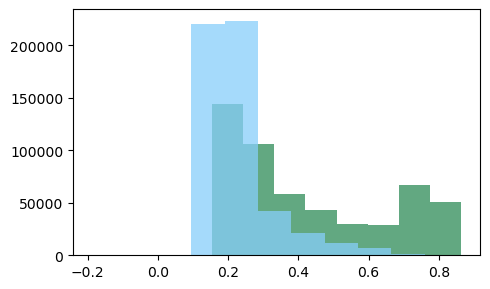

In [19]:
fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
ax.hist(ndvi_summer_array.flatten(), facecolor="seagreen", alpha=0.75)
ax.hist(ndvi_winter_array.flatten(), facecolor="lightskyblue", alpha=0.75)

In [20]:
print (f"Mean: {np.mean(ras_a)}")
print (f"Median: {np.median(ras_a)}")
print (f"Maximum: {np.max(ras_a)}")
print (f"Minimum: {np.min(ras_a)}")
print (f"Standard Deviation: {np.std(ras_a)}")
print (f"Percentile: {np.percentile(ras_a, 70)}")

Mean: 18.5
Median: 18.5
Maximum: 36
Minimum: 1
Standard Deviation: 10.388294694831615
Percentile: 25.5


In [21]:
print (f"Mean: {np.mean(ndvi_summer_array)}")

Mean: nan


In [22]:
print (f"Mean: {np.nanmean(ndvi_summer_array)}")
print (f"Median: {np.nanmedian(ndvi_summer_array)}")
print (f"Maximum: {np.nanmax(ndvi_summer_array)}")
print (f"Minimum: {np.nanmin(ndvi_summer_array)}")
print (f"Standard Deviation: {np.nanstd(ndvi_summer_array)}")
print (f"Percentile: {np.nanpercentile(ndvi_summer_array, 70)}")

Mean: 0.43034660816192627
Median: 0.3466057777404785
Maximum: 0.8641815185546875
Minimum: -0.024628784507513046
Standard Deviation: 0.2156597077846527
Percentile: 0.5576579570770264


### **Local operations**

#### Map algebra 
Below we demonstrate examples of how to use execute a variety of map algebra expressions on one or more arrays.

In [23]:
a = 12
b = 3
c = a/b
c

4.0

In [25]:
X2 =  ras_a*2
Sq = ras_a**2
ratio = ras_b/ras_a
mean = (X2+Sq)/2
ras_a_cap = np.where(ras_a > 25, 25, ras_a)

Text(0.5, 1.0, 'ras_a capped at 25')

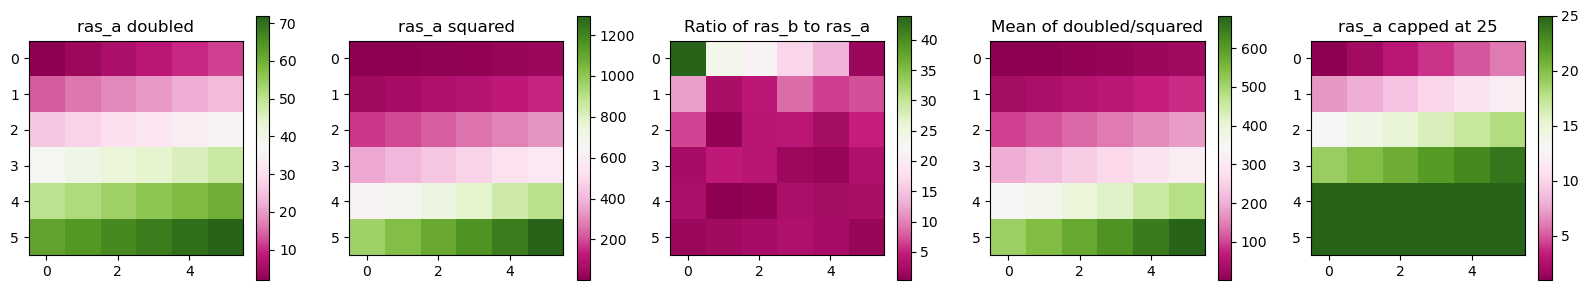

In [26]:
fig, axs = plt.subplots(1,5, figsize=(16,3), tight_layout=True)

plot0 = axs[0].imshow(X2, cmap="PiYG")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_a doubled")

plot1 = axs[1].imshow(Sq, cmap="PiYG")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("ras_a squared")

plot2 = axs[2].imshow(ratio, cmap="PiYG")
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("Ratio of ras_b to ras_a")

plot3 = axs[3].imshow(mean, cmap="PiYG")
fig.colorbar(plot3, ax=axs[3])
axs[3].set_title("Mean of doubled/squared")

plot4 = axs[4].imshow(ras_a_cap, cmap="PiYG")
fig.colorbar(plot4, ax=axs[4])
axs[4].set_title("ras_a capped at 25")

In [27]:
ndvi_diff_array = ndvi_summer_array - ndvi_winter_array

Text(0.5, 1.0, 'NDVI difference')

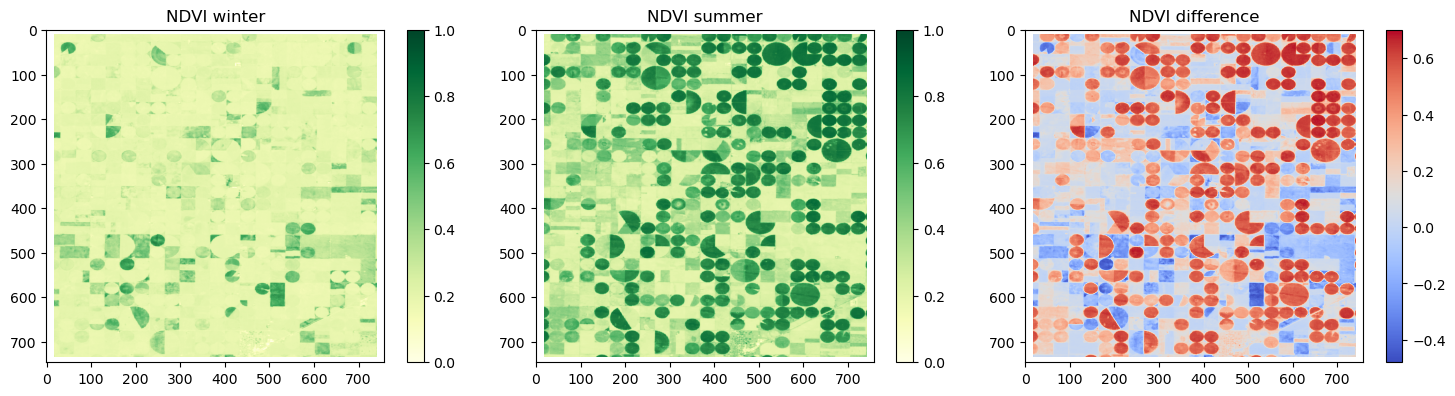

In [28]:
fig, axs = plt.subplots(1,3, figsize=(15,4), tight_layout=True)

plot0 = axs[0].imshow(ndvi_winter_array, cmap="YlGn", clim=(0,1))
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("NDVI winter")

plot1 = axs[1].imshow(ndvi_summer_array, cmap="YlGn",  clim=(0,1))
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("NDVI summer")

plot2 = axs[2].imshow(ndvi_diff_array, cmap="coolwarm")
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("NDVI difference")

#### Reclassify array data
Reclassification allows to reassign one or more values in a raster dataset to new output values.

In [29]:
reclassified = ras_a.copy()

reclassified[(reclassified > 0) & (reclassified <= 12)] = 1
reclassified[(reclassified > 12) & (reclassified <= 24)] = 2
reclassified[(reclassified > 24) & (reclassified <= 37)] = 3

Text(0.5, 1.0, 'ras_a reclassified')

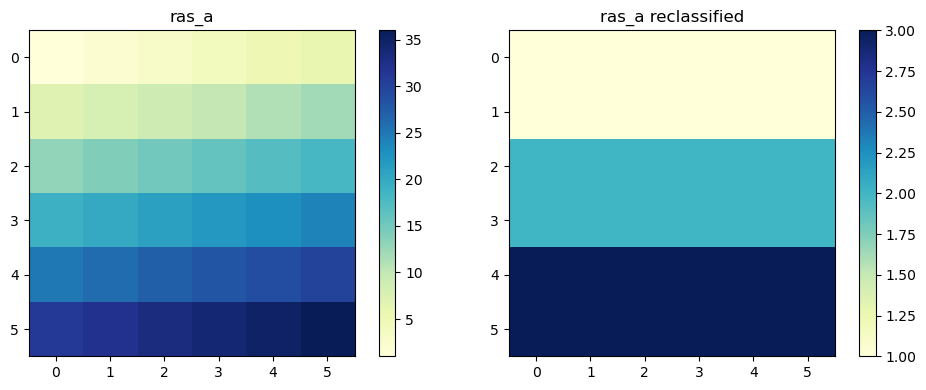

In [30]:
fig, axs = plt.subplots(1,2, figsize=(10,4), tight_layout=True)

plot0 = axs[0].imshow(ras_a, cmap="YlGnBu")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_a")

plot1 = axs[1].imshow(reclassified, cmap="YlGnBu")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("ras_a reclassified")

### **Focal operations**

#### Resample to a coarser resolution

In [31]:
scale_factor = 1/2
dataset = rasterio.open("./data-module-3/ras_a.tif")
aggregated = dataset.read(1, 
                          out_shape=(int(dataset.height * scale_factor), int(dataset.width * scale_factor)),
                          resampling=Resampling.nearest)
transform = dataset.transform * dataset.transform.scale(
    (dataset.width / aggregated.shape[0]),
    (dataset.height / aggregated.shape[1]))

Text(0.5, 1.0, 'ras_a aggregated')

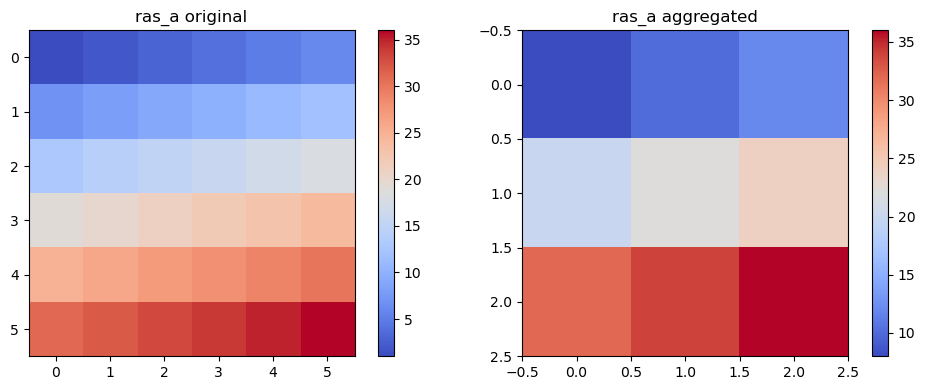

In [32]:
fig, axs = plt.subplots(1,2, figsize=(10,4), tight_layout=True)

plot0 = axs[0].imshow(ras_a, cmap="coolwarm")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_a original")

plot1 = axs[1].imshow(aggregated, cmap="coolwarm")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("ras_a aggregated")

In [33]:
scale_factor = 1/10
dataset = rasterio.open("./data-module-3/ndvi_summer.tif")
aggregated = dataset.read(1, 
                          out_shape=(int(dataset.height * scale_factor), int(dataset.width * scale_factor)),
                          resampling=Resampling.nearest)
aggregated[aggregated==dataset.nodata] = np.nan

Text(0.5, 1.0, 'NDVI aggregated')

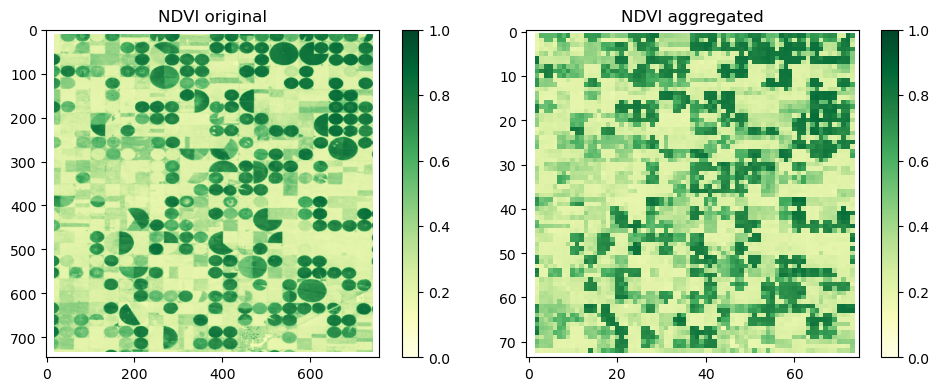

In [34]:
fig, axs = plt.subplots(1,2, figsize=(10,4), tight_layout=True)

plot0 = axs[0].imshow(ndvi_summer_array,  cmap="YlGn", clim=(0,1))
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("NDVI original")

plot1 = axs[1].imshow(aggregated,  cmap="YlGn", clim=(0,1))
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("NDVI aggregated")

#### Resample to a higher resolution

In [35]:
scale_factor = 2
dataset = rasterio.open("./data-module-3/ras_a.tif")

resampled_nearest = dataset.read(1, 
                          out_shape=(int(dataset.height * scale_factor), int(dataset.width * scale_factor)),
                          resampling=Resampling.nearest)
resampled_bilnear = dataset.read(1, 
                          out_shape=(int(dataset.height * scale_factor), int(dataset.width * scale_factor)),
                          resampling=Resampling.bilinear)

Text(0.5, 1.0, 'ras_a: bilinear resampling')

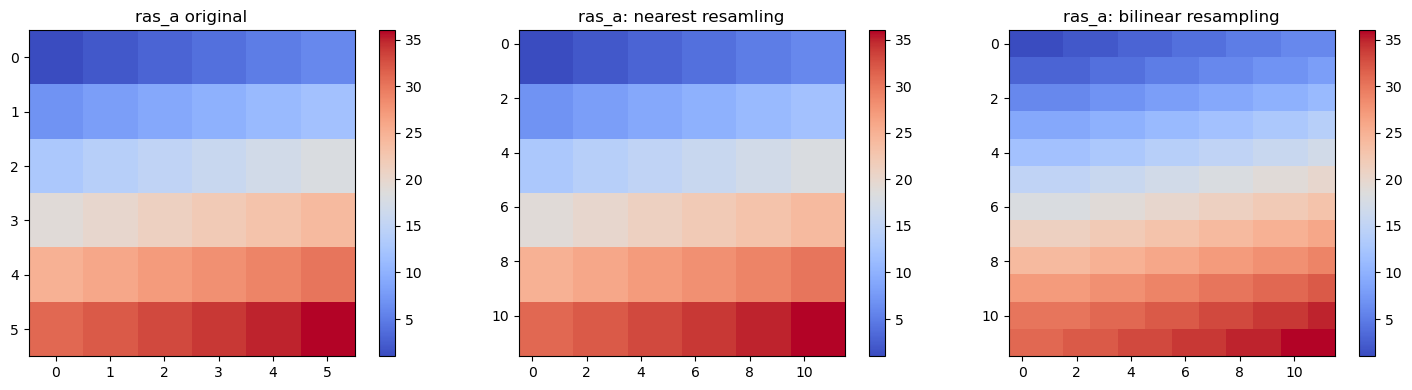

In [36]:
fig, axs = plt.subplots(1,3, figsize=(15,4), tight_layout=True)

plot0 = axs[0].imshow(ras_a, cmap="coolwarm")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_a original")

plot0 = axs[1].imshow(resampled_nearest, cmap="coolwarm")
fig.colorbar(plot0, ax=axs[1])
axs[1].set_title("ras_a: nearest resamling")

plot1 = axs[2].imshow(resampled_bilnear, cmap="coolwarm")
fig.colorbar(plot1, ax=axs[2])
axs[2].set_title("ras_a: bilinear resampling")

#### Apply focal statistics
Focal statistics calculates a statistic for input cells with a set of overlapping windows or neighborhoods defined as `kernel`. Please note that we use `xarray` and `xarray-spatial` packages to perfrom these operations.

In [37]:
ras_b_xr =  xr.DataArray(ras_b, dims=["y", "x"], name="raster b")
ras_b_xr

<xarray.DataArray 'raster b' (y: 6, x: 6)>
array([[44, 47, 64, 67, 67,  9],
       [83, 21, 36, 87, 70, 88],
       [88, 12, 58, 65, 39, 87],
       [46, 88, 81, 37, 25, 77],
       [72,  9, 20, 80, 69, 79],
       [47, 64, 82, 99, 88, 49]])
Dimensions without coordinates: y, x

In [38]:
ds = xr.Dataset(data_vars=dict(a = (["y", "x"], ras_a), b = (["y", "x"], ras_b)), 
                attrs=dict(description="Data we generated"))
ds

<xarray.Dataset>
Dimensions:  (y: 6, x: 6)
Dimensions without coordinates: y, x
Data variables:
    a        (y, x) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
    b        (y, x) int64 44 47 64 67 67 9 83 21 36 ... 69 79 47 64 82 99 88 49
Attributes:
    description:  Data we generated

In [39]:
kernel1 = circle_kernel(1,1,1)
focal1 = xrspatial.focal.focal_stats(ras_b_xr, kernel1, stats_funcs=["min"])[0]

kernel2 = np.ones([3,3])
focal2 = xrspatial.focal.focal_stats(ras_b_xr, kernel2, stats_funcs=["min"])[0]

In [40]:
kernel1

array([[0., 1., 0.],
       [1., 1., 1.],
       [0., 1., 0.]])

In [41]:
kernel2

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

Text(0.5, 1.0, 'min focal wtih custom kernel')

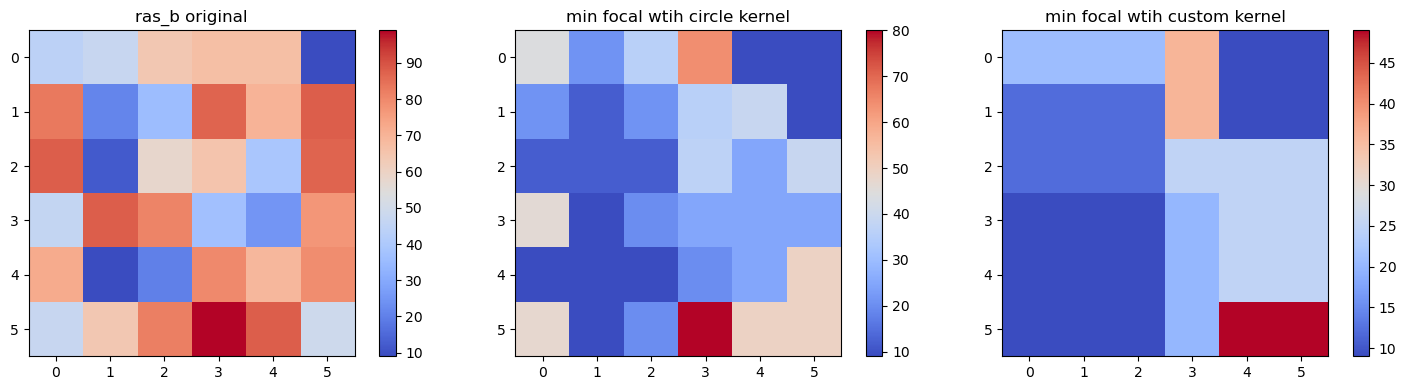

In [42]:
fig, axs = plt.subplots(1,3, figsize=(15,4), tight_layout=True)

plot0 = axs[0].imshow(ras_b, cmap="coolwarm")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("ras_b original")

plot1 = axs[1].imshow(focal1, cmap="coolwarm") 
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("min focal wtih circle kernel")

plot2 = axs[2].imshow(focal2, cmap="coolwarm") 
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("min focal wtih custom kernel")

In [43]:
ndvi_summer_xr =  xr.DataArray(ndvi_summer_array, dims=["y", "x"], name="ndvi_summer")
kernel = np.ones([15,15])
ndvi_summer_xr_focal = xrspatial.focal.focal_stats(ndvi_summer_xr, kernel, stats_funcs=["mean"])[0]
difference  = ndvi_summer_xr - ndvi_summer_xr_focal

Text(0.5, 1.0, 'Difference between original and focal')

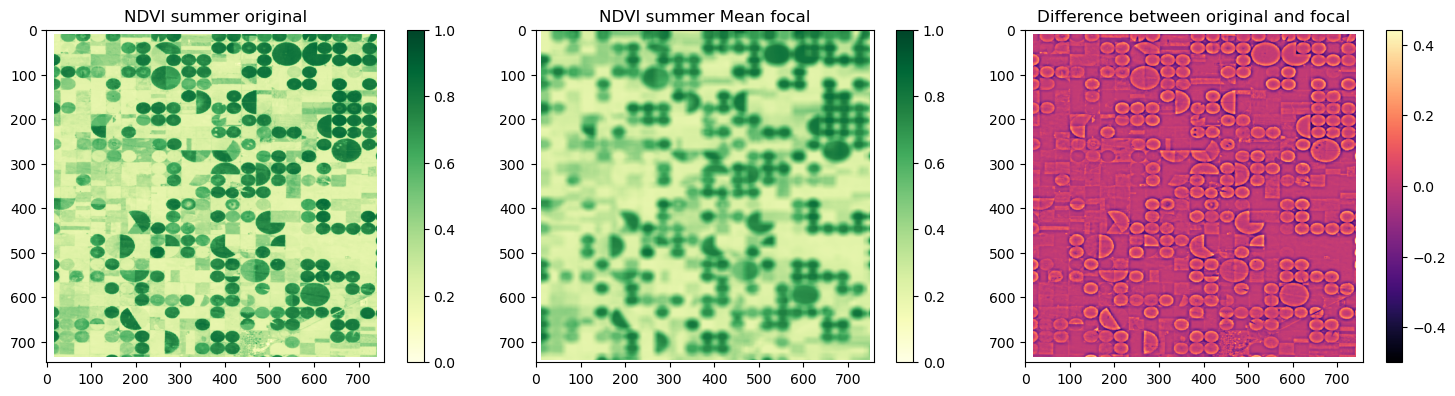

In [44]:
fig, axs = plt.subplots(1,3, figsize=(15,4), tight_layout=True)

plot0 = axs[0].imshow(ndvi_summer_xr, cmap="YlGn", clim=(0,1))
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("NDVI summer original")

plot1 = axs[1].imshow(ndvi_summer_xr_focal, cmap="YlGn", clim=(0,1)) 
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("NDVI summer Mean focal")

plot2 = axs[2].imshow(difference, cmap="magma") 
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("Difference between original and focal")

### **Zonal operations**

#### Summarize array by another array
Here we show how to calculate summary statistics for each zone defined by a `zones` dataset, based on `values` array.

In [45]:
np.random.seed(0)
categorical = np.random.randint(1,4, size=(6,6))

Text(0.5, 1.0, 'zones')

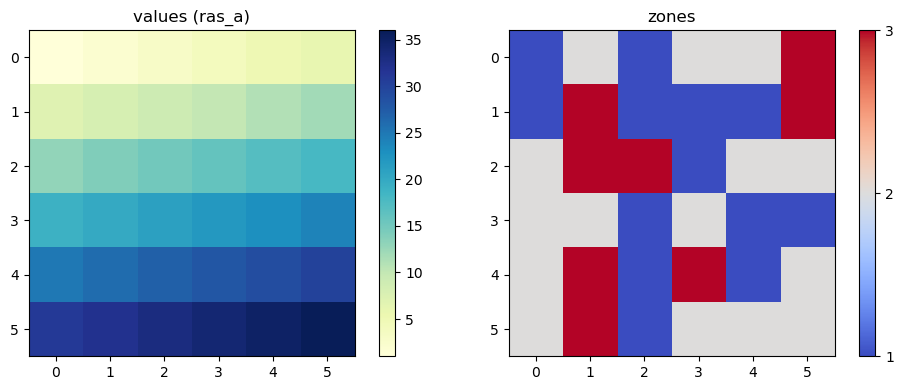

In [46]:
fig, axs = plt.subplots(1,2, figsize=(10,4), tight_layout=True)

plot0 = axs[0].imshow(ras_a, cmap="YlGnBu")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("values (ras_a)")

plot1 = axs[1].imshow(categorical, cmap="coolwarm")
fig.colorbar(plot1, ax=axs[1], ticks=[1,2,3])
axs[1].set_title("zones")

In [47]:
values = xr.DataArray(ras_a)
zones = xr.DataArray(categorical)
stats_df = xrspatial.zonal.stats(zones=zones, values=values)
stats_df

,zone,mean,max,min,sum,std,var,count
0,1,16.461538,33.0,1.0,214.0,9.997041,99.940828,13.0
1,2,20.733333,36.0,2.0,311.0,10.914618,119.128889,15.0
2,3,17.625000,32.0,6.0,141.0,9.109576,82.984375,8.0


#### Summarize array by vector geometries

In [48]:
fields_gdf = gpd.read_file("./data-module-3/ag_fields.shp")
fields_gdf

,FID,geometry
0,0,"POLYGON ((-100.56503 37.43511, -100.56515 37.4..."
1,1,"POLYGON ((-100.63781 37.42002, -100.63794 37.4..."
2,2,"POLYGON ((-100.53562 37.39656, -100.53571 37.3..."
3,3,"POLYGON ((-100.52811 37.37552, -100.52826 37.3..."
4,4,"POLYGON ((-100.64553 37.32350, -100.64564 37.3..."
5,5,"POLYGON ((-100.55534 37.30225, -100.55544 37.3..."
6,6,"POLYGON ((-100.55473 37.28217, -100.55472 37.2..."
7,7,"POLYGON ((-100.65473 37.25917, -100.65481 37.2..."
8,8,"POLYGON ((-100.60895 37.33828, -100.60904 37.3..."


Text(0.5, 1.0, 'NDVI summer')

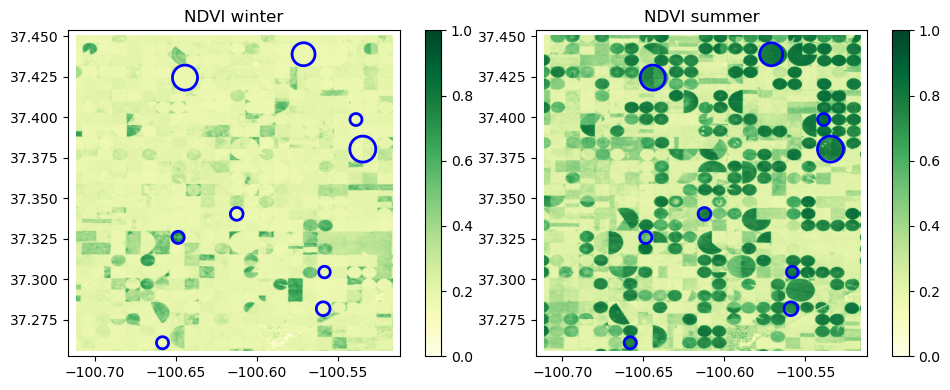

In [49]:
fig, axs = plt.subplots(1,2, figsize=(10,4), tight_layout=True)

plot_extent = plotting_extent(ndvi_winter_array, ndvi_winter.transform)

fields_gdf.plot(ax=axs[0], facecolor="none", edgecolor="blue", linewidth=2)

plot0 = axs[0].imshow(ndvi_winter_array, cmap="YlGn", clim=(0,1), extent=plot_extent)
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("NDVI winter")

fields_gdf.plot(ax=axs[1], facecolor="none", edgecolor="blue", linewidth=2)
plot1 = axs[1].imshow(ndvi_summer_array, cmap="YlGn",  clim=(0,1), extent=plot_extent)
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("NDVI summer")

In [50]:
zs = zonal_stats("./data-module-3/ag_fields.shp", "./data-module-3/ndvi_summer.tif", 
                 stats = ["mean", "max"])
zs

[{'max': 0.8368933200836182, 'mean': 0.7933672155179894},
 {'max': 0.8002122640609741, 'mean': 0.6829884708737864},
 {'max': 0.8619024753570557, 'mean': 0.8339374645336254},
 {'max': 0.8351208567619324, 'mean': 0.7283626066625226},
 {'max': 0.6414952278137207, 'mean': 0.5319198784364704},
 {'max': 0.830366313457489, 'mean': 0.774148682534913},
 {'max': 0.7883349657058716, 'mean': 0.6750924917367789},
 {'max': 0.7927654981613159, 'mean': 0.7470094301863783},
 {'max': 0.8227786421775818, 'mean': 0.750795907685251}]

In [52]:
fields_gdf["new column"] = fields_gdf.apply(lambda x: x.FID*2, axis=1)
fields_gdf

,FID,geometry,new column
0,0,"POLYGON ((-100.56503 37.43511, -100.56515 37.4...",0
1,1,"POLYGON ((-100.63781 37.42002, -100.63794 37.4...",2
2,2,"POLYGON ((-100.53562 37.39656, -100.53571 37.3...",4
3,3,"POLYGON ((-100.52811 37.37552, -100.52826 37.3...",6
4,4,"POLYGON ((-100.64553 37.32350, -100.64564 37.3...",8
5,5,"POLYGON ((-100.55534 37.30225, -100.55544 37.3...",10
6,6,"POLYGON ((-100.55473 37.28217, -100.55472 37.2...",12
7,7,"POLYGON ((-100.65473 37.25917, -100.65481 37.2...",14
8,8,"POLYGON ((-100.60895 37.33828, -100.60904 37.3...",16


In [53]:
fields_gdf["ndvi_winter"] = fields_gdf.apply(lambda x: zonal_stats(x.geometry, ndvi_winter_array, affine=ndvi_winter.transform, 
                                                         nodata=ndvi_winter.nodata, stats =["mean"])[0]["mean"], axis=1)
fields_gdf["ndvi_summer"] = fields_gdf.apply(lambda x: zonal_stats(x.geometry, ndvi_summer_array, affine=ndvi_summer.transform, 
                                                         nodata=ndvi_summer.nodata, stats =["mean"])[0]["mean"], axis=1)
fields_gdf

,FID,geometry,new column,ndvi_winter,ndvi_summer
0,0,"POLYGON ((-100.56503 37.43511, -100.56515 37.4...",0,0.176892,0.793367
1,1,"POLYGON ((-100.63781 37.42002, -100.63794 37.4...",2,0.180963,0.682988
2,2,"POLYGON ((-100.53562 37.39656, -100.53571 37.3...",4,0.173494,0.833937
3,3,"POLYGON ((-100.52811 37.37552, -100.52826 37.3...",6,0.203320,0.728363
4,4,"POLYGON ((-100.64553 37.32350, -100.64564 37.3...",8,0.656595,0.531920
5,5,"POLYGON ((-100.55534 37.30225, -100.55544 37.3...",10,0.183888,0.774149
6,6,"POLYGON ((-100.55473 37.28217, -100.55472 37.2...",12,0.182829,0.675092
7,7,"POLYGON ((-100.65473 37.25917, -100.65481 37.2...",14,0.170038,0.747009
8,8,"POLYGON ((-100.60895 37.33828, -100.60904 37.3...",16,0.185868,0.750796


### **Global operations**

#### Compute travel time to a destination

In [54]:
dataset =  rasterio.open("./data-module-3/friction_mali.tif")
friction = dataset.read(1)

In [55]:
destinations = [[600, 200], [100,500]]
mcp = graph.MCP_Geometric(friction, fully_connected=True, sampling=(dataset.res[0], dataset.res[1]))
cumulative_costs, traceback = mcp.find_costs(destinations)

Text(0.5, 1.0, 'Travel time (minutes)')

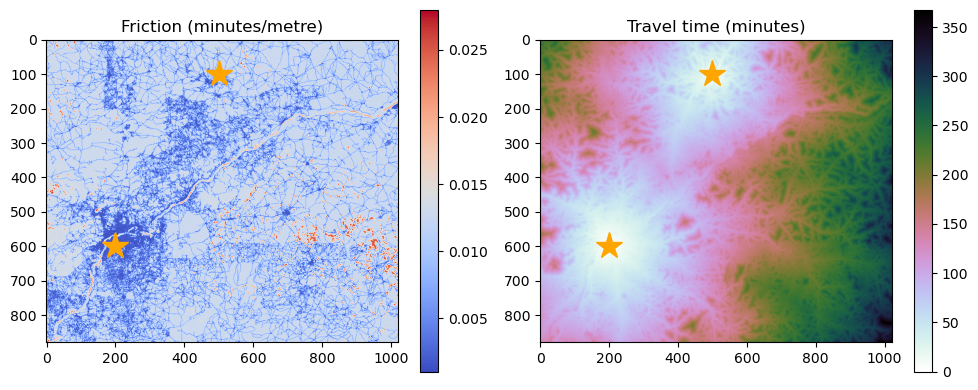

In [57]:
fig, axs = plt.subplots(1,2, figsize=(10,4), tight_layout=True)

axs[0].plot(destinations[0][1], destinations[0][0],'*', color="orange", markersize=20)
plot0 = axs[0].imshow(friction, cmap="coolwarm")
axs[0].plot(destinations[1][1], destinations[1][0],'*', color="orange", markersize=20) 
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("Friction (minutes/metre)")

plot1 = axs[1].imshow(cumulative_costs, cmap="cubehelix_r")
axs[1].plot(destinations[0][1], destinations[0][0],'*', color="orange", markersize=20)
axs[1].plot(destinations[1][1], destinations[1][0],'*', color="orange", markersize=20) 
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("Travel time (minutes)")

### **Exercises**
Your expercises will draw on datasets from the Spatial Production Allocation Model (SPAM) and Minnesota Geospatial Commons, which have been downloaded, cleaned, transformed, and saved to the directory `./data-module-3/` for this workshop.
#### Data
- `spam_H_MAIZ_A_mn.tif` (crop harvested area), `spam_P_MAIZ_A_mn.tif` (crop production) - agricultural indicators at 10x10km grid-cell resolution from SPAM (Spatial Production Allocation Model) data center  https://www.mapspam.info/data/
- `gw_provinces_extra.shp` - Groundwater Provinces of Minnesota derived from  https://gisdata.mn.gov/dataset/geos-groundwater-provinces-mn

**Question 1. Open raster files `spam_H_MAIZ_A_mn.tif` and `spam_P_MAIZ_A_mn.tif` and check their properties: Coordinate Reference System, extent, resolution, NoData, and transform.** 

**Question 2. Load arrays from the datasets opened in the previous question, reset NoData values, and plot them.**

**Question 3. Calculate a ratio of Production raster to Harvested Area to create an array Yield. Find statistics: maximum Yield and its standard deviation.**

**Question 4. Reclassify Yield array by using 3 categories (make your own breaks). Plot both for comparison.**

**Question 5: Resample Production raster to a coarser resolution. Plot both for comparison.**

**Question 6. Use focal statistics function on Yield array to create an array which shows the `mean` Yield within 3x3 cell neighborhood. Then create a raster map that displays the difference between each grid cell's Yield and `mean` Yield of its neighborhood. Plot the original raster, raster with focal statistics applied, and their difference raster as 3 subplots on the same figure.**

**Question 7. Open `gw_provinces_extra.shp`. Change the CRS of this `GeoDataFrame` to the CRS of the Production raster dataset.** 

**Question 8. Calculate zonal statistics of Production raster by groundwater provinces as `sum`. Append results to the groundwater provinces `GeoDataFrame`.**